<a href="https://colab.research.google.com/github/BrianCarela/LLM_stuff/blob/main/Copy_of_copula_insurance_nogroup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Copulas: Synthetizing the Insurance Dataset - Module 1</h1>
<p>
This notebook covers Module 1 of my course on synthetic data and generative AI. The method covered in this module is based on copulas applied to synthetic data, more specifically Gaussian copulas. In this version, I work with the non-categorical features. No grouping is performed: grouping and other aspects of the methodology are discussed in Module 2. All exercises proposed in this notebook are optional. You are welcome to work on some of them if you have extra time.
<p>
References to other synthetic data generation methods - for instance GAN (generative adversarial networks) - are provided only to show some strengths and weaknesses of copulas. GAN will be covered in module 3. But for now, you don't need to know what GANs are and how they work.  
<p>
The content is as follows:
    
<ol>
    <li><a href="#section1">Imports and Reading Datasets</a>  
    <li><a href="#section2">Exploratory Analysis</a>
    <li><a href="#section3">Step 1: Compute correlation matrix on real data</a>
    <li><a href="#section4">   Step 2: Multivariate Gaussian generation</a>
    <li><a href="#section5">   Step 3 and 4: From Gaussian to uniform to target distribution</a>
    <li><a href="#section5b">   Assessing Quality</a>
    <li><a href="#section6">  Synthetic Data: Snapshot</a>
    <li><a href="#section7">  Gathering More Stats and Insights</a>
    <li><a href="#section8">First Attempt at Parametric Copulas</a>
    <li><a href="#section9">More on parametrization</a>
</ol>

<a id='section1'></a>
<h2>1. Imports and Reading Dataset</h2>
<p>
The dataset on Kaggle, <a href="https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset">here</a>.
In this notebook, I use the version on my GitHub repository,
    <a href="https://github.com/VincentGranville/Main/blob/main/insurance.csv">here</a>.
<p>
<b>Features: </b> age, sex, bmi, children, smoker, region, charges.
<p>
The last one is the response. Categorical fields (sex, smoker, regions) to be treated separately. Check out for
outliers,
missing values,
values with commas inside,
and so on. Also, do we need to transform the data?
<p>
<b>Exercise 1</b><br>
Use dummy variables for categorical fields, and include them in the synthetization.

In [62]:
# copula_insurance_nogroup.py

import pandas as pd
from scipy.stats import norm
import numpy as np

# URL of the dataset
dataset_url = "https://raw.githubusercontent.com/VincentGranville/Main/main/insurance.csv"

# Read the dataset into a DataFrame
insurance_data = pd.read_csv(dataset_url)

# Print the first 10 rows of the dataset
print(insurance_data.head(10)) # a table of metrics taken by an insurance company

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
5   31  female  25.740         0     no  southeast   3756.62160
6   46  female  33.440         1     no  southeast   8240.58960
7   37  female  27.740         3     no  northwest   7281.50560
8   37    male  29.830         2     no  northeast   6406.41070
9   60  female  25.840         0     no  northwest  28923.13692


Now using numerical fields only: age, bmi, children, charges

In [63]:
# Extract individual features from the insurance data
ages = insurance_data.loc[:, "age"]
bmi_values = insurance_data.loc[:, "bmi"]
num_children = insurance_data.loc[:, "children"]
insurance_charges = insurance_data.loc[:, "charges"]

# Print the ages to verify
print(ages)

0       19
1       18
2       28
3       33
4       32
        ..
1333    50
1334    18
1335    18
1336    21
1337    61
Name: age, Length: 1338, dtype: int64


<a id='section2'></a>
<h2>2. Exploratory Analysis</h2>
<p>
The focus is to check out what kind of distributions we are dealing with, by plotting the distribution of each feature, and scatterplots for pair of features. In particular:
<ul>
<li> `ages` looks uniform except for the extremes (mixture of uniform and singular?)
<li> `bmi_values` looks Gaussian
<li> `num_children` looks like a geometric distribution
<li> `insurance_charges` is bimodal
</ul>

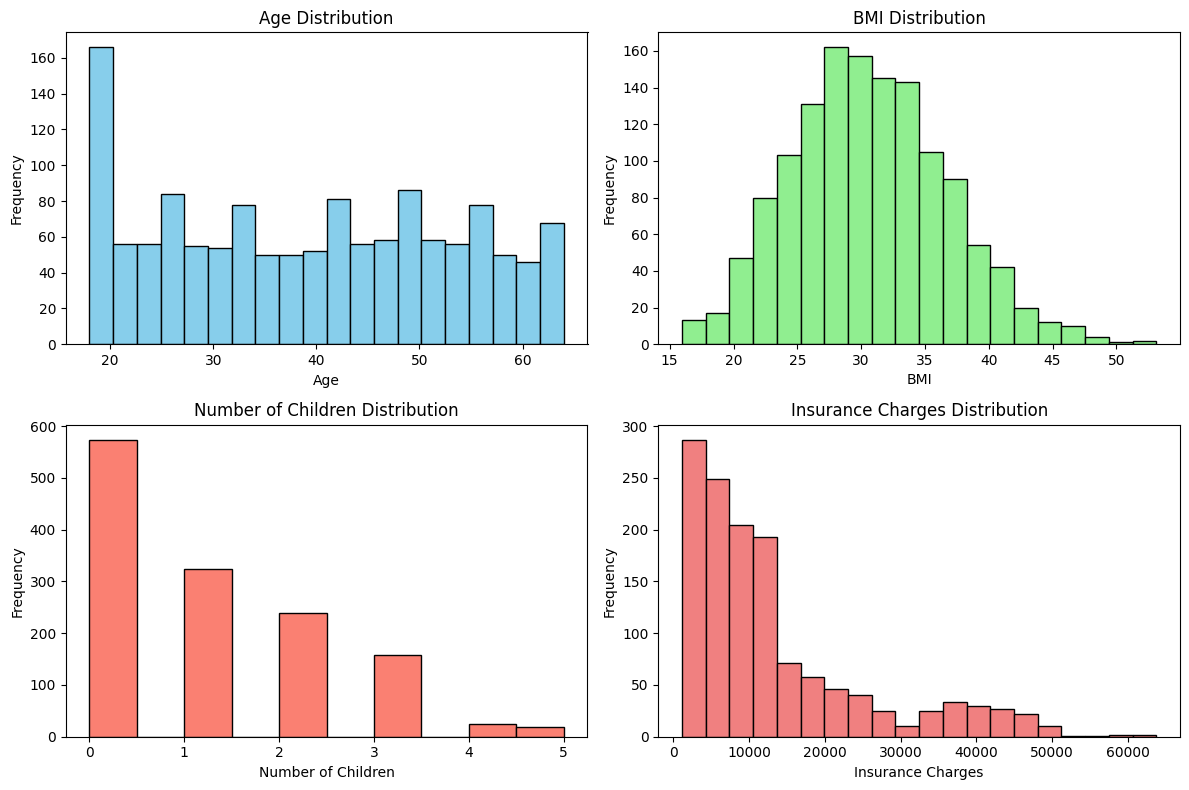

In [64]:
%matplotlib inline
# import matplotlib.pyplot as plt
# axes = plt.axes()
# n_bins = 20  # n_bins = 20 produces periodic spikes, why?
# plt.hist(ages, n_bins, density = True, rwidth = 0.8, color = 'green')

# ChatGPT helps me understand what im seeing below

import matplotlib.pyplot as plt

# Plot histograms to visualize the distribution of each feature
plt.figure(figsize=(12, 8))

# Age distribution
plt.subplot(2, 2, 1)
plt.hist(ages, bins=20, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# BMI distribution
plt.subplot(2, 2, 2)
plt.hist(bmi_values, bins=20, color='lightgreen', edgecolor='black')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')

# Number of children distribution
plt.subplot(2, 2, 3)
plt.hist(num_children, bins=10, color='salmon', edgecolor='black')
plt.title('Number of Children Distribution')
plt.xlabel('Number of Children')
plt.ylabel('Frequency')

# Insurance charges distribution
plt.subplot(2, 2, 4)
plt.hist(insurance_charges, bins=20, color='lightcoral', edgecolor='black')
plt.title('Insurance Charges Distribution')
plt.xlabel('Insurance Charges')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



**These metrics help insurance companies assess the risk profile of individuals apparently. When Density is true, it represents a probability distribution, but I like seeing the actual numbers because the visual gets the point across anyways.**


<a id='section3'></a>
<h2>3. Step 1: Compute correlation matrix on real data</h2>

Given $m$ features (in this case including the response - the charges incurred by the insurance company for each policyholder), the correlation matrix is an $m \times m$ symmetric matrix with entries between -1 and +1. All diagonal entries are +1. The entry in column $i$ and row $j$ is the correlation $c_{ij}$ between features $i$ and $j$, computed on the real data. It is computed as
<p>
$$
C_{ij} = \frac{1}{ns_i s_j}\sum_{k=1}^n (X_{ki} - \overline{X}_{\cdot i})(X_{kj} - \overline{X}_{\cdot j})
$$
<p>
where $s_i, s_j$ are the standard deviations respectively for the $i$-th and $j$-th features. Here $m=4$, $n$ is the number of observations or policyholders in the real data set, and $X_{ki}$ is the value attached to the $i$-th feature in the $k$-th observation. We want the synthetic data to have a correlation matrix very similar to that computed on the real data. Rescaling the observations (transforming the data with a linear transform, for instance for standardization purposes) has no effect on the correlation matrix: it is scale and location invariant.

Alright, let's break this down using a video game analogy:

Imagine you're playing a game where you have a team of characters with different abilities. Each character has various stats like strength, speed, intelligence, and luck. These stats represent different features of your team members.

Now, the correlation matrix is like a map that shows how these stats are related to each other. It's a big grid where each row and column represents a different stat, and the numbers inside show how closely related each pair of stats are.

For example, let's say you have a stat called "Strength" and another called "Speed." The number in the grid where the row for "Strength" intersects with the column for "Speed" tells you how much those two stats tend to go together. If the number is positive, it means that when one stat goes up, the other tends to go up too. If it's negative, it means they tend to move in opposite directions.

Now, the formula mentioned is like a special tool you use to calculate these numbers in the correlation matrix. You go through each pair of stats for each team member, calculate how they vary together across all team members, and then take an average. This gives you a number that represents the correlation between those two stats across your whole team.

The formula involves some math lingo like standard deviation and averages, but think of it like calculating an average score for each pair of stats to see how they're related.

And remember, this correlation matrix helps you understand which stats are important and how they work together in your team. In our case, it's used with insurance data to understand how different factors like age, BMI, and number of children relate to insurance charges.

In [65]:
from IPython.display import display

# Compute correlation matrix on real data, for Gaussian copula
r_data = np.stack((ages, bmi_values, num_children, insurance_charges), axis=0)
r_corr = np.corrcoef(r_data)

# Define row and column labels
labels = ["Age", "BMI", "Children", "Charges"]

# Create DataFrame with correlation matrix and labels
corr_df = pd.DataFrame(r_corr, columns=labels, index=labels)

# Style the DataFrame for better presentation
styled_corr_df = corr_df.style.background_gradient(cmap='coolwarm').format(precision=2)

# Display the styled DataFrame
display(styled_corr_df)

,Age,BMI,Children,Charges
Age,1.00,0.11,0.04,0.30
BMI,0.11,1.00,0.01,0.20
Children,0.04,0.01,1.00,0.07
Charges,0.30,0.20,0.07,1.00


Also computing the means for each feature. Not needed here, but useful to see if they make sense and get an idea.

In [66]:
# r_mu  = [np.mean(age), np.mean(bmi), np.mean(children), np.mean(charges)]
# nobs_synth = len(age)
# print("Mean: %5.2f %5.2f %5.2f %6.0f" % (r_mu[0],r_mu[1],r_mu[2],r_mu[3]))
# print("Nobs: %4d" %(nobs_synth))
# zero = [0, 0, 0, 0]

from IPython.display import HTML

# Compute the mean of each feature: age, BMI, number of children, and insurance charges
mean_values = [np.mean(ages), np.mean(bmi_values), np.mean(num_children), np.mean(insurance_charges)]

# Get the number of observations (number of individuals in the dataset)
num_observations = len(ages)

# Create a DataFrame to display mean values and number of observations
summary_data = {
    'Feature': ['Age', 'BMI', 'Number of Children', 'Insurance Charges', 'Number of Observations'],
    'Value': [f"{mean_values[0]:.2f}", f"{mean_values[1]:.2f}", f"{mean_values[2]:.2f}", f"{mean_values[3]:.0f}", num_observations]
}

summary_df = pd.DataFrame(summary_data)

# Style the DataFrame for better presentation
styled_summary_df = summary_df.style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
)

# Display the styled DataFrame
display(styled_summary_df)

# Create a list of zeros with the same length as the number of features (used later for multivariate Gaussian generation)
zero_mean = [0, 0, 0, 0]

,Feature,Value
0,Age,39.21
1,BMI,30.66
2,Number of Children,1.09
3,Insurance Charges,13270
4,Number of Observations,1338


<a id='section4'></a>
<h2>4. Step 2: Multivariate Gaussian generation</h2>
<p>A multivariate Gaussian distribution describes the joint distribution of multiple variables (like character stats) together, accounting for their individual normal distributions and the relationships between them.</p>
<p>
Generate multivariate Gaussian with zero mean and covariance equal to correlation matrix on real data. We generate <code>nobs_synth</code> observations. In this case, the same number as in the real data. The use of a Gaussian copula here is similar to using Gaussians for the latent data in GAN. There are alternatives, such as Frank copula, in the same way that you could use (say) uniform deviates for latent features in GAN. If some features in the real data have very thick tail, a Gaussian copula, though theoretically correct (especially if the dataset is large) may undersample extremes.
<p>
First, we want to control all sources of randomness for replicability and to study volatility. This is done with <code>seed</code>. When saving results, don't forget to save the seed that you used as well.

In [67]:
seed = 453
np.random.seed(seed)

In [68]:
# this step to reconstruct correl structure in synth. data
# basically create a copy

# Calculate the mean of each feature: age, BMI, number of children, and charges
mean_values = [np.mean(ages), np.mean(bmi_values), np.mean(num_children), np.mean(insurance_charges)]
std_values = [np.std(ages), np.std(bmi_values), np.std(num_children), np.std(insurance_charges)]
print("Mean values:", mean_values)
print("Standard deviation values:", std_values)

# Number of observations in the synthetic data (same as the real data)
nobs_synth = len(ages)

# Generate synthetic data using a multivariate normal distribution
synthetic_data = np.random.multivariate_normal(zero_mean, r_corr, nobs_synth)

# Extract the age, BMI, number of children, and charges for each synthetic superhero
synthetic_ages = synthetic_data[:, 0]
synthetic_bmi_values = synthetic_data[:, 1]
synthetic_num_children = synthetic_data[:, 2]
synthetic_charges = synthetic_data[:, 3]

# Create a DataFrame to store the synthetic data
synthetic_df = pd.DataFrame({
    'Age': synthetic_ages,
    'BMI': synthetic_bmi_values,
    'Number of Children': synthetic_num_children,
    'Charges': synthetic_charges
})

# Convert the synthetic data to z-scores
synthetic_df_z = (synthetic_df - mean_values) / std_values

# Limit the DataFrame to the first 20 rows for display
limited_synthetic_df_z = synthetic_df_z.head(20)

# Style the limited DataFrame for better presentation
styled_limited_synthetic_df_z = limited_synthetic_df_z.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)

# Display the styled limited DataFrame
display(styled_limited_synthetic_df_z)

# Keep the mean vector and zero mean vector for future use
print("Mean vector (r_mu):", mean_values)
print("Zero mean vector:", zero_mean)

Mean values: [39.20702541106129, 30.66339686098655, 1.0949177877429, 13270.422265141257]
Standard deviation values: [14.044709038954522, 6.0959076415894256, 1.2050421724928497, 12105.484975561612]


,Age,BMI,Number of Children,Charges
0,-2.84,-4.91,0.05,-1.10
1,-2.81,-5.06,-0.10,-1.10
2,-2.82,-5.18,-0.81,-1.10
3,-2.90,-5.13,-0.30,-1.10
4,-2.86,-5.16,-2.63,-1.10
5,-2.84,-5.07,0.09,-1.10
6,-2.85,-5.09,-2.05,-1.10
7,-2.81,-5.16,-1.28,-1.10
8,-2.74,-5.03,-0.64,-1.10
9,-2.92,-5.28,-0.66,-1.10


Mean vector (r_mu): [39.20702541106129, 30.66339686098655, 1.0949177877429, 13270.422265141257]
Zero mean vector: [0, 0, 0, 0]


This table displays the synthetic data, with values represented as standard deviations (z-scores) from the mean of the original data. The color gradient indicates the distance from the mean, where cooler colors (blue) are closer to the mean (0) and warmer colors (red) are further away. Note that the synthetic data was generated using a zero mean vector, which may result in values that differ from the original distribution's mean. (that's why this looks so off)

<a id='section5'></a>
<h2>5. Step 3 and 4: From Gaussian to uniform to target distribution</h2>
<p>
From the correlated Gaussian with the target correlation structure, extract marginals (the features) and turn them into uniforms on [0, 1]. Then transform the uniforms into the correct target distribution: the empirical distribution of the real data, for each feature. The correlation structure is preserved.

In [69]:
# Generate synthetic data

# List to store transformed synthetic data
transformed_synthetic_data = []

# Step 3 and 4: Transform Gaussian to Uniform to Target Distribution
for i in range(nobs_synth):

    # Step 3: Convert Gaussian-distributed features to uniform distribution [0, 1]
    u_age = norm.cdf(synthetic_ages[i])
    u_bmi = norm.cdf(synthetic_bmi_values[i])
    u_num_children = norm.cdf(synthetic_num_children[i])
    u_charges = norm.cdf(synthetic_charges[i])

    # Step 4: Transform uniform distribution to target empirical distribution
    t_age = np.quantile(ages, u_age)                    # Transform age
    t_bmi = np.quantile(bmi_values, u_bmi)              # Transform BMI
    t_num_children = np.quantile(num_children, u_num_children) # Transform number of children
    t_charges = np.quantile(insurance_charges, u_charges)      # Transform charges

    # Append the transformed values to the list
    transformed_synthetic_data.append((t_age, t_bmi, t_num_children, t_charges))

# Convert the list to a NumPy array
transformed_synthetic_data = np.array(transformed_synthetic_data)

# Create a DataFrame to store the transformed synthetic data
transformed_synthetic_df = pd.DataFrame(transformed_synthetic_data, columns=['Age', 'BMI', 'Number of Children', 'Charges'])

# Limit the DataFrame to the first 20 rows for display
limited_transformed_synthetic_df = transformed_synthetic_df.head(20)

# Style the limited DataFrame for better presentation
styled_transformed_synthetic_df = limited_transformed_synthetic_df.style.background_gradient(cmap='coolwarm').format(precision=2)

# Display the styled limited DataFrame
display(styled_transformed_synthetic_df)


,Age,BMI,Number of Children,Charges
0,26.00,35.20,3.00,7203.62
1,34.00,29.19,2.00,9526.73
2,32.00,24.76,1.00,9381.26
3,19.00,26.89,2.00,3333.07
4,23.00,25.67,0.00,9793.25
5,27.00,28.84,3.00,21223.70
6,24.00,28.00,0.00,2903.97
7,33.00,25.53,0.00,6626.61
8,51.00,30.35,1.00,12920.08
9,18.00,21.75,1.00,4932.77


The synthetic values represent the z scores, how far from the average (as a standard deviation) the value is.

Then norm.cdf converts these into a number that better represents how under/over the average the value should be.

Then np.quantile turns these values into actual quantities that make sense by the data, but they're not the exact values of the original data set. Instead, it's new "random" values but they make sense as a collection because the relationships that the values have with each other are consistent with the relationships that the values of the original dataset have with each other.

<a id='sectionx'></a>
<h2>6. Assessing Quality</h2>

In [70]:
# Calculate the mean of each feature in the synthetic data
synthetic_means = np.mean(transformed_synthetic_data, axis=0)

# Print the means of the synthetic data
print("Mean Synthetic Data: %5.2f %5.2f %5.2f %6.0f" % (synthetic_means[0], synthetic_means[1], synthetic_means[2], synthetic_means[3]))

# Print the means of the real data
print("Mean Real Data     : %5.2f %5.2f %5.2f %6.0f" % (mean_values[0], mean_values[1], mean_values[2], mean_values[3]))

# Create a DataFrame to compare the means
comparison_df = pd.DataFrame({
    'Feature': ['Age', 'BMI', 'Number of Children', 'Charges'],
    'Synthetic Mean': synthetic_means,
    'Real Mean': mean_values
})

# Style the DataFrame for better presentation
styled_comparison_df = comparison_df.style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
).format(precision=2)

# Display the styled DataFrame
display(styled_comparison_df)

Mean Synthetic Data: 38.84 30.65  1.02  13328
Mean Real Data     : 39.21 30.66  1.09  13270


,Feature,Synthetic Mean,Real Mean
0,Age,38.84,39.21
1,BMI,30.65,30.66
2,Number of Children,1.02,1.09
3,Charges,13327.62,13270.42


In [71]:
# Calculate the correlation matrix for the synthetic data
synthetic_corr_matrix = np.corrcoef(np.transpose(transformed_synthetic_data))

# Print the correlation matrix for the real data
print("Correlation, Real Data:\n")
print(r_corr)

# Print the correlation matrix for the synthetic data
print("\nCorrelation, Synthetic Data:\n")
print(synthetic_corr_matrix)

# Create DataFrames to store the correlation matrices for better presentation
real_corr_df = pd.DataFrame(r_corr, columns=['Age', 'BMI', 'Number of Children', 'Charges'], index=['Age', 'BMI', 'Number of Children', 'Charges'])
synthetic_corr_df = pd.DataFrame(synthetic_corr_matrix, columns=['Age', 'BMI', 'Number of Children', 'Charges'], index=['Age', 'BMI', 'Number of Children', 'Charges'])

# Style the DataFrames for better presentation
styled_real_corr_df = real_corr_df.style.background_gradient(cmap='coolwarm').format(precision=2)
styled_synthetic_corr_df = synthetic_corr_df.style.background_gradient(cmap='coolwarm').format(precision=2)

# Display the styled DataFrames
print("Correlation Matrix - Real Data")
display(styled_real_corr_df)

print("Correlation Matrix - Synthetic Data")
display(styled_synthetic_corr_df)

Correlation, Real Data:

[[1.         0.10927188 0.042469   0.29900819]
 [0.10927188 1.         0.0127589  0.19834097]
 [0.042469   0.0127589  1.         0.06799823]
 [0.29900819 0.19834097 0.06799823 1.        ]]

Correlation, Synthetic Data:

[[1.         0.09547703 0.02413221 0.28762577]
 [0.09547703 1.         0.05036735 0.15233377]
 [0.02413221 0.05036735 1.         0.05744995]
 [0.28762577 0.15233377 0.05744995 1.        ]]
Correlation Matrix - Real Data


,Age,BMI,Number of Children,Charges
Age,1.00,0.11,0.04,0.30
BMI,0.11,1.00,0.01,0.20
Number of Children,0.04,0.01,1.00,0.07
Charges,0.30,0.20,0.07,1.00


Correlation Matrix - Synthetic Data


,Age,BMI,Number of Children,Charges
Age,1.00,0.10,0.02,0.29
BMI,0.10,1.00,0.05,0.15
Number of Children,0.02,0.05,1.00,0.06
Charges,0.29,0.15,0.06,1.00


<b>Exercise 2</b><br>
Check if pairwise feature scatter plots on real and synth. data are similar.
<p>
<b>Exercise 3</b><br>    
Try with different seeds. Assess volatility of the results. Compute confidence intervals for mean age and so on.

<a id='section6'></a>
<h2>7. Synthetic Data: Snapshot</h2>

In [72]:
# Convert the transformed synthetic data (numpy array) to a pandas DataFrame
synthetic_data_df = pd.DataFrame(transformed_synthetic_data, columns=['Age', 'BMI', 'Number of Children', 'Charges'])

# Display the first 10 rows of the DataFrame
print("Snapshot of the Synthetic Data (First 10 Rows):")
display(synthetic_data_df.head(10).style.background_gradient(cmap='coolwarm').format(precision=2))

Snapshot of the Synthetic Data (First 10 Rows):


,Age,BMI,Number of Children,Charges
0,26.00,35.20,3.00,7203.62
1,34.00,29.19,2.00,9526.73
2,32.00,24.76,1.00,9381.26
3,19.00,26.89,2.00,3333.07
4,23.00,25.67,0.00,9793.25
5,27.00,28.84,3.00,21223.70
6,24.00,28.00,0.00,2903.97
7,33.00,25.53,0.00,6626.61
8,51.00,30.35,1.00,12920.08
9,18.00,21.75,1.00,4932.77


Second look at the top 10 rows, I like being reminded what the synthetic data looks like

In [73]:
# Transpose the real data to switch rows and columns
transposed_real_data = np.transpose(r_data)

# Convert the transposed real data (numpy array) to a pandas DataFrame
real_data_df = pd.DataFrame(transposed_real_data, columns=['Age', 'BMI', 'Number of Children', 'Charges'])

# Display the first 10 rows of the DataFrame
print("Snapshot of the Real Data (First 10 Rows):")
display(real_data_df.head(10).style.background_gradient(cmap='coolwarm').format(precision=2))

Snapshot of the Real Data (First 10 Rows):


,Age,BMI,Number of Children,Charges
0,19.00,27.90,0.00,16884.92
1,18.00,33.77,1.00,1725.55
2,28.00,33.00,3.00,4449.46
3,33.00,22.70,0.00,21984.47
4,32.00,28.88,0.00,3866.86
5,31.00,25.74,0.00,3756.62
6,46.00,33.44,1.00,8240.59
7,37.00,27.74,3.00,7281.51
8,37.00,29.83,2.00,6406.41
9,60.00,25.84,0.00,28923.14


Real data snapshot for comparison

<a id='section7'></a>
<h2>8. Gathering More Stats and Insights</h2>
<p>
The goal is to better compare synthetic with real data, and save summary stats for future comparison with other seeds (to assess volatility) and other methods: GAN, copula with grouping (to reduce algorithmic bias), Frank copula, copula with empirical quantiles replaced by parametric distributions fit to the real data, and feature substitution to reduce algorithmic bias.

In [74]:
# Calculate minimum values for each feature in the real and synthetic data
real_min = np.min(real_data_df, axis=0)
synthetic_min = np.min(synthetic_data_df, axis=0)

# Calculate maximum values for each feature in the real and synthetic data
real_max = np.max(real_data_df, axis=0)
synthetic_max = np.max(synthetic_data_df, axis=0)

# Calculate standard deviations for each feature in the real and synthetic data
real_std = np.std(real_data_df, axis=0)
synthetic_std = np.std(synthetic_data_df, axis=0)

# Create DataFrames to store the summary statistics for comparison
summary_stats_df = pd.DataFrame({
    'Feature': ['Age', 'BMI', 'Number of Children', 'Charges'],
    'Real Min': real_min,
    'Synthetic Min': synthetic_min,
    'Real Max': real_max,
    'Synthetic Max': synthetic_max,
    'Real Std': real_std,
    'Synthetic Std': synthetic_std
})

# Style the DataFrame for better presentation
styled_summary_stats_df = summary_stats_df.style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
).format(precision=3)

# Display the styled DataFrame
print("Summary Statistics - Real vs Synthetic Data")
display(styled_summary_stats_df)

Summary Statistics - Real vs Synthetic Data


,Feature,Real Min,Synthetic Min,Real Max,Synthetic Max,Real Std,Synthetic Std
Age,Age,18.000,18.000,64.000,64.000,14.045,13.975
BMI,BMI,15.960,15.997,53.130,53.095,6.096,6.115
Number of Children,Number of Children,0.000,0.000,5.000,5.000,1.205,1.189
Charges,Charges,1121.874,1133.380,63770.428,62555.918,12105.485,12047.968


<b>Exercise 4</b><br>
Add 25- and 75-percentiles, both for real and synthetic.
<p>
<b>Exercise 5</b><br>
Compute distance between statistical summaries on real and synthetized data. To do so, transform real data so that each feature has zero mean and unit variance. Make the comparison between standardized data and the synth data produced on the standardized version of the real data. Then try different seeds, and see which ones provide best fit.
<p>
<b>Exercise 6</b><br>
In addition to the above statistics in Exercise 5, also include the correlation matrices. No don't need to transform the data here: these matrices are invariant under linear transformations. To be discussed in the GAN module.
<p>
<b>Exercise 7</b><br>
Instead of summary stats, use Hellinger distance for comparison purposes: (1) feature-wise, (2) max or average Hellinger across features.

<b>Conclusions</b><p>
The copulas do a great job at replicating the correlation structure and marginal distributions. They work with both ordinal and continuous features, producing ordinal values for ordinal features. Replication of the results is easy thanks to
<code>seed</code>. Also, it is a very fast technique. We will see that copulas, unlike GANs, are not great at replicating non linear structures (correlation is a linear structure). Also, unless using parametric distributions for the quantiles, you can't sample outside the range of observations (min, max) in the real data. This issue is true for all features, but easy to fix.

<a id='section8'></a>
<h2>9. First Attempt at Parametric Copulas</h2>
<p>
Let's replace the empirical quantiles for 'children' by quantiles of a geometric distribution of parameter <em>p</em>.
The parameter is estimated on the real data, as the inverse of the mean for the feature in question. The
feature <code>t_num_children</code> obtained in the synthetic data will have a
sister feature <code>t_num_children_geom</code>. See what happens when we switch them. Are the results worse? Are we able to sample outside the range? (that was the purpose). Likewise, we could use a GMM (Gaussian mixture model) for the bimodal 'charges', preferably after a log-transform to make sure we do not generate negative charges in the synthetic data (and typically, expenses may follow a log-normal rather than normal distribution).

In [75]:
# Calculate the mean of the 'children' feature
mean_children = np.mean(num_children)

# Estimate the parameter for the geometric distribution
children_geom_param = 1 - mean_children / (mean_children + 1)  # numpy geometric distribution starts at 1, we adjust to start at 0

# Generate synthetic 'children' data using the geometric distribution
synthetic_children_geom = np.random.geometric(children_geom_param, len(num_children))
synthetic_children_geom = synthetic_children_geom - np.ones(len(num_children))  # Adjust to start at 0

# List to store the new version of transformed synthetic data
transformed_synthetic_data_v2 = []

# Transform the synthetic data using parametric copulas
for i in range(nobs_synth):
    # Step 3: Convert Gaussian-distributed features to uniform distribution [0, 1]
    u_age = norm.cdf(synthetic_ages[i])
    u_bmi = norm.cdf(synthetic_bmi_values[i])
    u_num_children = norm.cdf(synthetic_num_children[i])
    u_charges = norm.cdf(synthetic_charges[i])

    # Step 4: Transform uniform distribution to target empirical and parametric distributions
    t_age = np.quantile(ages, u_age)  # Transform age
    t_bmi = np.quantile(bmi_values, u_bmi)  # Transform BMI
    t_num_children = np.quantile(num_children, u_num_children)  # Transform number of children
    t_num_children_geom = np.quantile(synthetic_children_geom, u_num_children)  # Transform geometric number of children
    t_charges = np.quantile(insurance_charges, u_charges)  # Transform charges

    # Append the transformed values to the list
    transformed_synthetic_data_v2.append((t_age, t_bmi, t_num_children, t_charges, t_num_children_geom))

# Convert the list to a NumPy array
transformed_synthetic_data_v2 = np.array(transformed_synthetic_data_v2)

# Create a DataFrame to store the new version of transformed synthetic data
synthetic_data_v2_df = pd.DataFrame(transformed_synthetic_data_v2, columns=['Age', 'BMI', 'Number of Children', 'Charges', 'Geom Children'])

# Display the first 10 rows of the new version of synthetic data
print("Snapshot of the New Version of Synthetic Data (First 10 Rows):")
display(synthetic_data_v2_df.head(10).style.background_gradient(cmap='coolwarm').format(precision=2))


Snapshot of the New Version of Synthetic Data (First 10 Rows):


,Age,BMI,Number of Children,Charges,Geom Children
0,26.00,35.20,3.00,7203.62,3.00
1,34.00,29.19,2.00,9526.73,2.00
2,32.00,24.76,1.00,9381.26,1.00
3,19.00,26.89,2.00,3333.07,2.00
4,23.00,25.67,0.00,9793.25,0.00
5,27.00,28.84,3.00,21223.70,3.00
6,24.00,28.00,0.00,2903.97,0.00
7,33.00,25.53,0.00,6626.61,0.00
8,51.00,30.35,1.00,12920.08,1.00
9,18.00,21.75,1.00,4932.77,1.00


Now checking some summary stats. Check out for maximum number of children in children_geom. In some instances it was too high, meaning a geometric distribution is not a great fit. It does sample outside the range and reduces overfit if present, but a truncated geometric or a 2-param distribution is probably a better fit.

In [77]:
import pandas as pd
import numpy as np
from IPython.display import display

# Calculate minimum values for each feature in the new synthetic data
synthetic_min_v2 = np.min(transformed_synthetic_data_v2, axis=0)

# Calculate maximum values for each feature in the new synthetic data
synthetic_max_v2 = np.max(transformed_synthetic_data_v2, axis=0)

# Calculate mean values for each feature in the new synthetic data
synthetic_mean_v2 = np.mean(transformed_synthetic_data_v2, axis=0)

# Calculate standard deviations for each feature in the new synthetic data
synthetic_std_v2 = np.std(transformed_synthetic_data_v2, axis=0)

# Calculate the correlation matrix for the new synthetic data
synthetic_corr_v2 = np.corrcoef(np.transpose(transformed_synthetic_data_v2))

# Calculate minimum, maximum, mean, and standard deviation for each feature in the real data
real_min = np.min(real_data_df, axis=0)
real_max = np.max(real_data_df, axis=0)
real_mean = np.mean(real_data_df, axis=0)
real_std = np.std(real_data_df, axis=0)

# Calculate the correlation matrix for the real data
real_corr = np.corrcoef(np.transpose(real_data_df))

# Create DataFrame to store the summary statistics for real data
real_stats_df = pd.DataFrame({
    'Feature': ['Age', 'BMI', 'Number of Children', 'Charges'],
    'Real Min': real_min,
    'Real Max': real_max,
    'Real Mean': real_mean,
    'Real Std': real_std
})

# Create DataFrame to store the summary statistics for synthetic data including 'Geom Children'
synthetic_stats_v2_df = pd.DataFrame({
    'Feature': ['Age', 'BMI', 'Number of Children', 'Charges', 'Geom Children'],
    'Synthetic Min V2': synthetic_min_v2,
    'Synthetic Max V2': synthetic_max_v2,
    'Synthetic Mean V2': synthetic_mean_v2,
    'Synthetic Std V2': synthetic_std_v2
})

# Style the DataFrames for better presentation
styled_real_stats_df = real_stats_df.style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
).format(precision=3)

styled_synthetic_stats_v2_df = synthetic_stats_v2_df.style.set_properties(**{'text-align': 'left'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
).format(precision=3)

# Display the styled DataFrames
print("Summary Statistics - Real Data")
display(styled_real_stats_df)

print("Summary Statistics - Synthetic Data V2")
display(styled_synthetic_stats_v2_df)

# Print correlation matrices
print("\nCorrelation Matrix - Real Data:")
display(pd.DataFrame(real_corr, columns=['Age', 'BMI', 'Number of Children', 'Charges'], index=['Age', 'BMI', 'Number of Children', 'Charges']).style.background_gradient(cmap='coolwarm').format(precision=2))

print("\nCorrelation Matrix - Synthetic Data V2:")
display(pd.DataFrame(synthetic_corr_v2, columns=['Age', 'BMI', 'Number of Children', 'Charges', 'Geom Children'], index=['Age', 'BMI', 'Number of Children', 'Charges', 'Geom Children']).style.background_gradient(cmap='coolwarm').format(precision=2))

# Additional comparison for children features
print("\tNumber of Children | Geometric Children | Real Children\n")
print("Min\t%2d\t%2d\t%2d" % (synthetic_min_v2[2], synthetic_min_v2[4], real_min[2]))
print("Max\t%2d\t%2d\t%2d" % (synthetic_max_v2[2], synthetic_max_v2[4], real_max[2]))
print("Mean\t%5.3f\t%5.3f\t%5.3f" % (synthetic_mean_v2[2], synthetic_mean_v2[4], real_mean[2]))
print("Std\t%5.3f\t%5.3f\t%5.3f" % (synthetic_std_v2[2], synthetic_std_v2[4], real_std[2]))

Summary Statistics - Real Data


,Feature,Real Min,Real Max,Real Mean,Real Std
Age,Age,18.000,64.000,39.207,14.045
BMI,BMI,15.960,53.130,30.663,6.096
Number of Children,Number of Children,0.000,5.000,1.095,1.205
Charges,Charges,1121.874,63770.428,13270.422,12105.485


Summary Statistics - Synthetic Data V2


,Feature,Synthetic Min V2,Synthetic Max V2,Synthetic Mean V2,Synthetic Std V2
0,Age,18.000,64.000,38.839,13.975
1,BMI,15.997,53.095,30.650,6.115
2,Number of Children,0.000,5.000,1.020,1.189
3,Charges,1133.380,62555.918,13327.617,12047.968
4,Geom Children,0.000,9.433,1.069,1.488



Correlation Matrix - Real Data:


,Age,BMI,Number of Children,Charges
Age,1.00,0.11,0.04,0.30
BMI,0.11,1.00,0.01,0.20
Number of Children,0.04,0.01,1.00,0.07
Charges,0.30,0.20,0.07,1.00



Correlation Matrix - Synthetic Data V2:


,Age,BMI,Number of Children,Charges,Geom Children
Age,1.00,0.10,0.02,0.29,0.03
BMI,0.10,1.00,0.05,0.15,0.05
Number of Children,0.02,0.05,1.00,0.06,0.95
Charges,0.29,0.15,0.06,1.00,0.05
Geom Children,0.03,0.05,0.95,0.05,1.00


	Number of Children | Geometric Children | Real Children

Min	 0	 0	 0
Max	 5	 9	 5
Mean	1.020	1.069	1.095
Std	1.189	1.488	1.205


Now showing frequency and cumulative distribution for $(n_1, n_2)$ where $n_1$ is number of children
 computed one way, and $n_2$ the number of children computed another way. The three ways are: real data, synthetic parameter-free,
  and synthetic with parametric (geometric) distribution. Good fit means that for a large chunk of the joint distribution, $n_1 = n_2$ or both are close.

In [ ]:
def bivariate_counts(column1, column2):
    count = {}
    for k in range(nobs_synth):
        n_children1 = int(column1[k]+0.5)
        n_children2 = int(column2[k]+0.5)
        key = (n_children1,n_children2)
        if key in count:
            count[key] += 1
        else:
            count[key]=1
    cnt = 0
    print("    (n1, n2)    freq.  cumul_freq.")
    for w in sorted(count, key = count.get, reverse = True):
        cnt += count[w]
        skey = str(w)
        freq = count[w]/nobs_synth
        cfreq = cnt/nobs_synth
        print("%10s\t%4.3f\t%4.3f" % (skey, freq, cfreq))
    return()

s_data_children = s_data_v2[:,2]       # parameter-free synthesized
s_data_children_param = s_data_v2[:,4] # parametric model (geom. distrib.)
r_data_t = np.transpose(r_data)        # real data
r_data_children = []
for k in range(nobs_synth):
    r_data_children.append(r_data_t[k][2])

bivariate_counts(s_data_children_param, r_data_children)

<a id='section9'></a>
<h2>10. More on Parametrization</h2>
<p>
We will explore this topic in more details in Module 2. This is a quick overview to give you an idea of the possibilities.    
<p>    
One way to improve the distribution for the children is to choose a distribution with two parameters, rather than one. A truncated geometric is a good candidate. It allows you to match both the mean and the variance in the real data. The code below uses a Zipf-geometric distribution with two parameters $p$ and $a$ for this purpose. It is one of the many generalized geometric distribution (see more <a href="https://www.ccsenet.org/journal/index.php/ijsp/article/view/69051">here</a>) and defined by
<p>
$$P(X = k) = C\cdot\frac{p^k}{(k+1)^a},\quad k=0,1,2,\dots$$
<p>
where $0\leq p \leq 1$ and $C$ is a constant so that the sum of the probabilities is equal to 1. Here $X$ represents the number of children. The code below performs severa tasks:
<ul>    
<li> Estimating $p$ and $a$ based on the real data so that the sampled mean and variance in the synthetic data match those computed on the real data. I use an optimized grid search to solve this problem.
<li> Sampling from the distribition in question, using the estimated parameters, to produce a replacement of <code>children_geom</code> in the methodoly used earlier. This time, the maximum number of children is 7 rather than 9, a nice improvement.   
<li> The last part (optional) produces a contour map of the cost function to optimize, to find the best $p$ and $a$. This is typicall performed using a gradient algorithm, here I used a very efficient grid search instead.
</ul>
Everything about the 'children' applies to other features and even to joint combinations of multiple features.

In [ ]:
import numpy as np

def ZipfGeom(p, a):
    C = 0
    for k in range(100):
        C += p**k/(k+1)**a
    mu = 0
    m2 = 0
    for k in range(100):
        mu += k*p**k/(k+1)**a
        m2 += k*k*p**k/(k+1)**a
    mu /= C
    m2 /= C
    var = m2 - mu*mu
    stdev = var**(1/2)
    return(mu, stdev)

#--- optimized grid search to find optimal p and a

def grid_search(grid_range):
    p_min = grid_range[0][0]
    p_max = grid_range[0][1]
    a_min = grid_range[1][0]
    a_max = grid_range[1][1]
    p_step = (p_max - p_min)/10
    a_step = (a_max - a_min)/10
    min_delta = 999999999.9
    for p in np.arange(p_min, p_max, p_step):
        for a in np.arange(a_min, a_max, a_step):
            (mu, std) = ZipfGeom(p, a)
            delta = np.sqrt((mu - target_mu)**2 + (std - target_std)**2)
            if delta < min_delta:
                p_best = p
                a_best = a
                mu_best = mu
                std_best = std
                min_delta = delta
    return(p_best, a_best, mu_best, std_best, min_delta)

#--- estimating p and a based on observed mean and standard deviation

target_mu  = 1.095
target_std = 1.205

p = 0.5
a = 0.0
step_p = 0.4
step_a = 3.0

for level in range(3):
    step_p /= 2
    step_a /= 2
    p_min = max(0, p - step_p)
    p_max = p + step_p
    a_min = a - step_a
    a_max = a + step_a
    grid_range = [(p_min, p_max),(a_min, a_max)]
    (p, a, mu, std, min_delta) = grid_search(grid_range)
    print("delta: %6.4f mu: %6.4f std: %6.4f p: %6.4f a: %6.4f"
         % (min_delta, mu, std, p, a))

#--- sampling using estimated p and a

C = 0
for k in range(100):
    C += p**k/(k+1)**a
arr_CDF = []
CDF = 0
for k in range(100):
    CDF += (p**k/(k+1)**a)/C
    arr_CDF.append(CDF)

def sample_from_CDF(arr_CDF):
    u = np.random.uniform(0,1)
    k = 0
    while u > arr_CDF[k]:
        k = k+1
    return(k)

nobs = 1400  # number of deviates to produce
seed = 500
np.random.seed(seed)
sample = np.empty(nobs)
for n in range(nobs):
    k = sample_from_CDF(arr_CDF)
    sample[n] = k

mean = np.mean(sample)
std  = np.std(sample)
max  = max(sample)
print("\nSample stats: mean: %5.3f std: %5.3f max: %5.3f"
   % (mean, std, max))

#--- optional: plotting approximation error for p, a

from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm # color maps

xa = np.arange(0.0, 0.6, 0.005)
ya = np.arange(-3.0, 0.0, 0.025)
xa, ya = np.meshgrid(xa, ya)
za = np.empty(shape=(len(xa),len(ya)))

kk = 0
for p in np.arange(0.0, 0.6, 0.005):
    hh = 0
    for a in np.arange(-3.0, 0.0, 0.025):
        (mu, std) = ZipfGeom(p, a)
        delta = np.sqrt((mu - target_mu)**2 + (std - target_std)**2)
        za[hh, kk] = delta
        hh += 1
    kk += 1

mpl.rcParams['axes.linewidth'] = 0.5
fig = plt.figure()
axes = plt.axes()
axes.tick_params(axis='both', which='major', labelsize=8)
axes.tick_params(axis='both', which='minor', labelsize=8)
CS = axes.contour(xa, ya, za, levels=150, cmap=cm.coolwarm, linewidths=0.35)
cbar = fig.colorbar(CS, ax = axes, shrink = 0.8, aspect = 5)
cbar.ax.tick_params(labelsize=8)
plt.show()


The above picture shows the parameter space for the zeta-geometric distribution. I used
<a href="https://mltechniques.com/2023/03/30/smart-grid-search-case-study-with-hybrid-zeta-geometric-distributions-and-synthetic-data/">smart grid search</a> (the above algorithm) to find the parameters that match those estimated on the real data.
<p>
The image below show that you can do better with a two-parameter zeta-geometric distribution, compared to a one-parameter geometric distribution. With the zeta-geometric, you are able to match both the variance and mean for the number of children. The geometric distribution overestimates the maximum number of children when it correctly reproduces the mean.
<p>
<img style="float: left;" src="https://raw.githubusercontent.com/VincentGranville/Notebooks/main/zetageom.png" width=400>